In [42]:
import os
import requests
import pandas as pd
# from deta import Deta
from dotenv import load_dotenv
from utils import upload
import dropbox

load_dotenv()

# deta = Deta(os.environ.get("DETA_PROJECT_KEY"))

# drive = deta.Drive("data")

# anomaly_detection_ranges = pd.read_csv('https://drive.deta.sh/v1/b0x22rtxtdf/data/files/download?name=anomaly_detection_ranges.csv', storage_options={'X-API-Key':os.environ.get("DETA_PROJECT_KEY")})
anomaly_detection_ranges = pd.read_csv('https://www.dropbox.com/scl/fi/fjz0am427gw35sz7l994m/anomaly_detection_ranges.csv?rlkey=lib9w0jz2zei5n566jv76o7ol&dl=1')

anomaly_detection_ranges.ds = pd.to_datetime(anomaly_detection_ranges.ds)

# current_df = pd.read_csv('https://drive.deta.sh/v1/b0x22rtxtdf/data/files/download?name=current.csv', storage_options={'X-API-Key':os.environ.get("DETA_PROJECT_KEY")})
current_df = pd.read_csv('https://www.dropbox.com/scl/fi/4zmm1bpwtrhrqtvce8aqq/current.csv?rlkey=1wnfrlal5jefwkx4fg7jxl20o&dl=1')

current_df.ds = pd.to_datetime(current_df.ds)
current = current_df.head(1).iloc[0]

anomaly_detection_ranges = anomaly_detection_ranges.set_index('ds').loc[current.ds]

alert_types = [
                'INFLOW_STRETCHER',
                # 'Infl_Stretcher_cum',
                'INFLOW_AMBULATORY',
                # 'Infl_Ambulatory_cum',
                'Inflow_Total',
                # 'Inflow_Cum_Total',
                'INFLOW_AMBULANCES',
                # 'Infl_Ambulances_cum',
                # 'FLS',
                # 'CUM_ADMREQ',
                # 'CUM_BA1',
                # 'WAITINGADM',
                # 'TTStr',
                'TRG_HALLWAY1',
                'TRG_HALLWAY_TBS',
                # 'reoriented_cum',
                # 'reoriented_cum_MD',
                'QTRACK1',
                # 'RESUS',
                # 'Pod_T',
                # 'POD_GREEN',
                'POD_GREEN_TBS',
                # 'POD_YELLOW',
                'POD_YELLOW_TBS',
                # 'POD_ORANGE',
                'POD_ORANGE_TBS',
                'POD_CONS_MORE2H',
                'POD_IMCONS_MORE4H',
                'POD_XRAY_MORE2H',
                'POD_CT_MORE2H',
                # 'POST_POD1',
                # 'VERTSTRET',
                'RAZ_TBS',
                # 'RAZ_LAZYBOY',
                # 'RAZ_WAITINGREZ',
                # 'AMBVERT1',
                'AMBVERTTBS',
                'QTrack_TBS',
                # 'Garage_TBS',
                'RAZ_CONS_MORE2H',
                'RAZ_IMCONS_MORE4H',
                'RAZ_XRAY_MORE2H',
                'RAZ_CT_MORE2H1',
                # 'PSYCH1',
                # 'PSYCH_WAITINGADM'
                ]

alerts = []

for column in alert_types:
    try:
        if current[column] > anomaly_detection_ranges[column+'_yhat_upper']:
            alerts.append({'metric': column, 'value': current[column], 'yhat_upper': round(
                anomaly_detection_ranges[column+'_yhat_upper'], 1), 'ds':current.ds})
    except:
        continue

alerts_df = pd.DataFrame(alerts)

# alerts_df.to_csv('alerts.csv', index=False)
# alerts_df.to_excel('alerts.xlsx', index_label="index")




In [ ]:

# drive.put(name='alerts.csv',
#           path='alerts.csv')
try:
    dropbox_app_key = os.environ.get("DROPBOX_APP_KEY")
    dropbox_app_secret = os.environ.get("DROPBOX_APP_SECRET")
    dropbox_refresh_token = os.environ.get("DROPBOX_REFRESH_TOKEN")

    # exchange the authorization code for an access token:
    token_url = "https://api.dropboxapi.com/oauth2/token"
    params = {
        "grant_type": "refresh_token",
        "refresh_token": dropbox_refresh_token,
        "client_id": dropbox_app_key,
        "client_secret": dropbox_app_secret
    }
    r = requests.post(token_url, data=params)
    # print(r.text)

    dropbox_access_token = r.json()['access_token']

    dbx = dropbox.Dropbox(dropbox_access_token)
    
    upload(dbx, 'alerts.csv', '', '',
               'alerts.csv', overwrite=True)
    upload(dbx, 'alerts.xlsx', '', '',
               'alerts.xlsx', overwrite=True)
except:
    print('unable to upload to dropbox')



In [43]:
print(alerts_df)

Empty DataFrame
Columns: []
Index: []


In [44]:
for i,row in alerts_df.iterrows():
    print(row.metric)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the data from the uploaded CSV file
file_path = 'https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
# data.head()

data = data.tail(365*24)

# print(data.head())

def create_metric_graph(metric):
    # Calculate total patients to be seen as the sum of specified columns

    # Extract hour from the timestamp for grouping
    data['Hour'] = pd.to_datetime(data['ds']).dt.hour

    # Group by hour and calculate the average number of patients for each hour
    hourly_data = data.groupby('Hour')[metric].mean()

    # Identify the most recent timestamp's hour and its corresponding value
    most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
    most_recent_hour = most_recent_timestamp.hour
    most_recent_value = data.loc[pd.to_datetime(data['ds']) == most_recent_timestamp, metric].iloc[0]

    # Extract the day of the week for the most recent timestamp
    most_recent_day_of_week = most_recent_timestamp.dayofweek

    # Filter the data to include only rows matching the same day of the week
    same_day_data = data[pd.to_datetime(data['ds']).dt.dayofweek == most_recent_day_of_week]

    # Group by hour and calculate the average number of patients for this specific day of the week
    hourly_data_same_day = same_day_data.groupby('Hour')[metric].mean()


    # Plot the updated graph with colors matching the example and no vertical grid lines
    plt.figure(figsize=(12, 6))
    plt.bar(hourly_data_same_day.index, hourly_data_same_day, color='#5293ff', alpha=0.8, label='Historical Mean (Same Day)')
    plt.bar(
        most_recent_hour, most_recent_value, color='#ff4d4d', alpha=0.6, label='Most Recent Data'
    )
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.title(f'Patient Volume: Historical Mean for {most_recent_day_of_week} vs Most Recent Data', fontsize=16)
    plt.xticks(range(0, 24), fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(False, axis='x')  # Remove vertical grid lines
    plt.tight_layout()
    plt.show()
    # plt.savefig(metric+'.png')

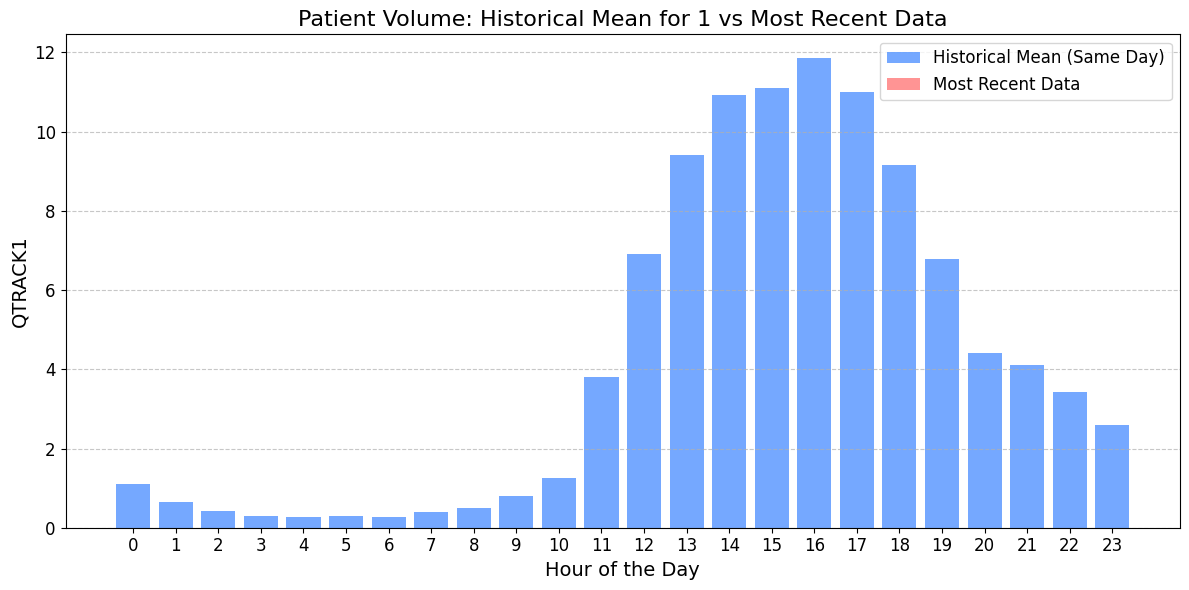

In [49]:
create_metric_graph('QTRACK1')

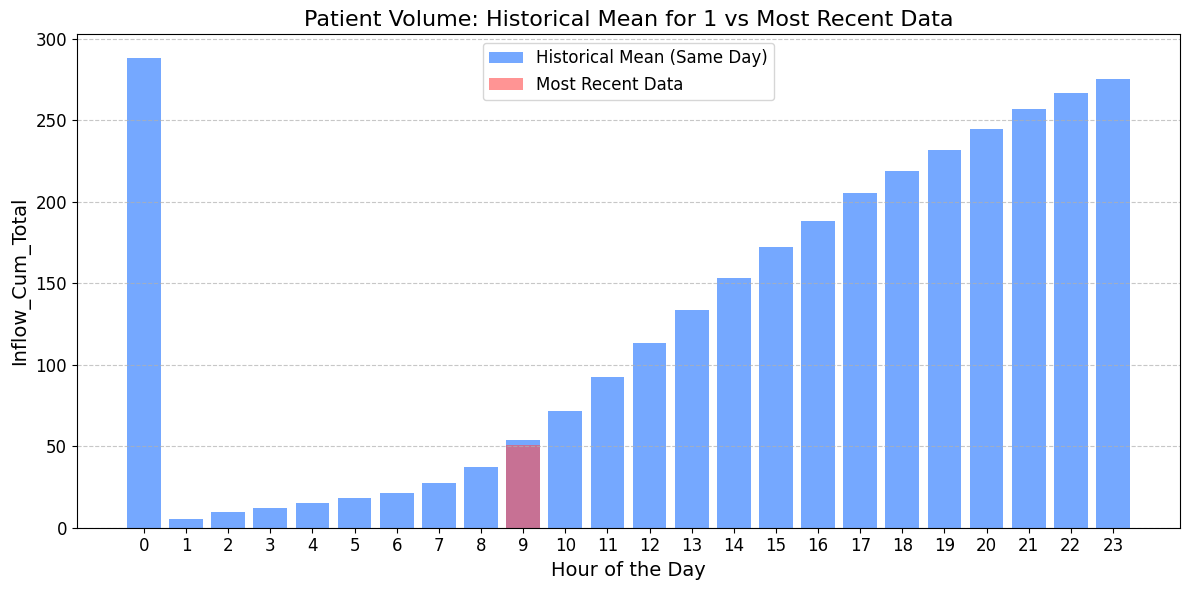

In [47]:
create_metric_graph('Inflow_Cum_Total')

In [16]:
data.head()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,AMBVERTTBS,QTrack_TBS,Garage_TBS,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,Hour
0,2021-01-01 01:00:00,1,1,1,1,2,2,0,0,0,...,0,0.0,0.0,1,0,0,0,3,3,1
1,2021-01-01 02:00:00,2,3,1,2,3,5,1,1,0,...,2,0.0,0.0,1,1,0,0,3,3,2
2,2021-01-01 03:00:00,0,3,1,3,1,6,0,1,0,...,1,0.0,0.0,0,0,0,0,3,3,3
3,2021-01-01 04:00:00,1,4,0,3,1,7,1,2,0,...,0,0.0,0.0,0,0,0,0,4,3,4
4,2021-01-01 05:00:00,1,5,1,4,2,9,1,3,0,...,1,0.0,0.0,0,0,0,0,4,3,5
